Each task that is proposed to be completed as part of the homework has a declared "price" in points. The maximum possible amount is 10 points, and together with the bonus assignment - 12 points. It is not necessary to complete all the tasks, only a part can be done. Most of the points expect you to write working Python code; sometimes you will need to write comments - for example, to compare several approaches to solve the same problem. Also you can add more cells for your convenience if you need.

This homework focuses on clustering. We will work with images of handwritten digits, learn how to cluster them using two different methods (hierarchical clustering and the 𝐾-means algorithm), evaluate the quality of the partition and choose the optimal number of clusters, as well as visualize intermediate results.

In [70]:
import numpy as np
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.neighbors import NearestCentroid
from sklearn.metrics import silhouette_score, v_measure_score, accuracy_score
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.datasets import fetch_openml

plt.rcParams["figure.figsize"] = (18,8)

## 1. Loading data
The data we will be working with is available in the scikit-learn library (`sklearn` module) in the `datasets` submodule via the `load_digits` function. The data contains 1,797 observations, each of which is 8×8 pixel image of a handwritten digit from 0 to 9. This is about the same amount of each digit (about 180).

For convenience, every image expands to a 64 (8×8) row, so entire numpy array is 1797×64. The color intensity in each pixel is encoded with an integer from 0 to 16.

In addition to images, their labels are also known. In this task, we will assume that the labels (as well as their amount) are unknown and try to group the data in such a way that the resulting clusters 'better match' the original ones. Possible options for determining the 'better match' are presented later.

**(0.25 points)** Load the images into `X` variable, and their labels into `y` variable.

In [4]:
X, y = load_digits(return_X_y=True, as_frame=True)

In [5]:
assert X.shape == (1797, 64)
assert y.shape == (1797,)

**(0.5 points)** Visualize the first 10 images.

- Arrange images on a grid rather than in a row. You may need the `subplot` and `imshow` functions from the `pyplot` module in the `matplotlib` library.
- You will also need to reshape the images to 8×8.
- Remove ticks and labels from both axes. The `xticks` and `yticks` functions or the `tick_params` function from `pyplot` can help you with this.
- Make the output good sized with the `figure` function from `pyplot`.

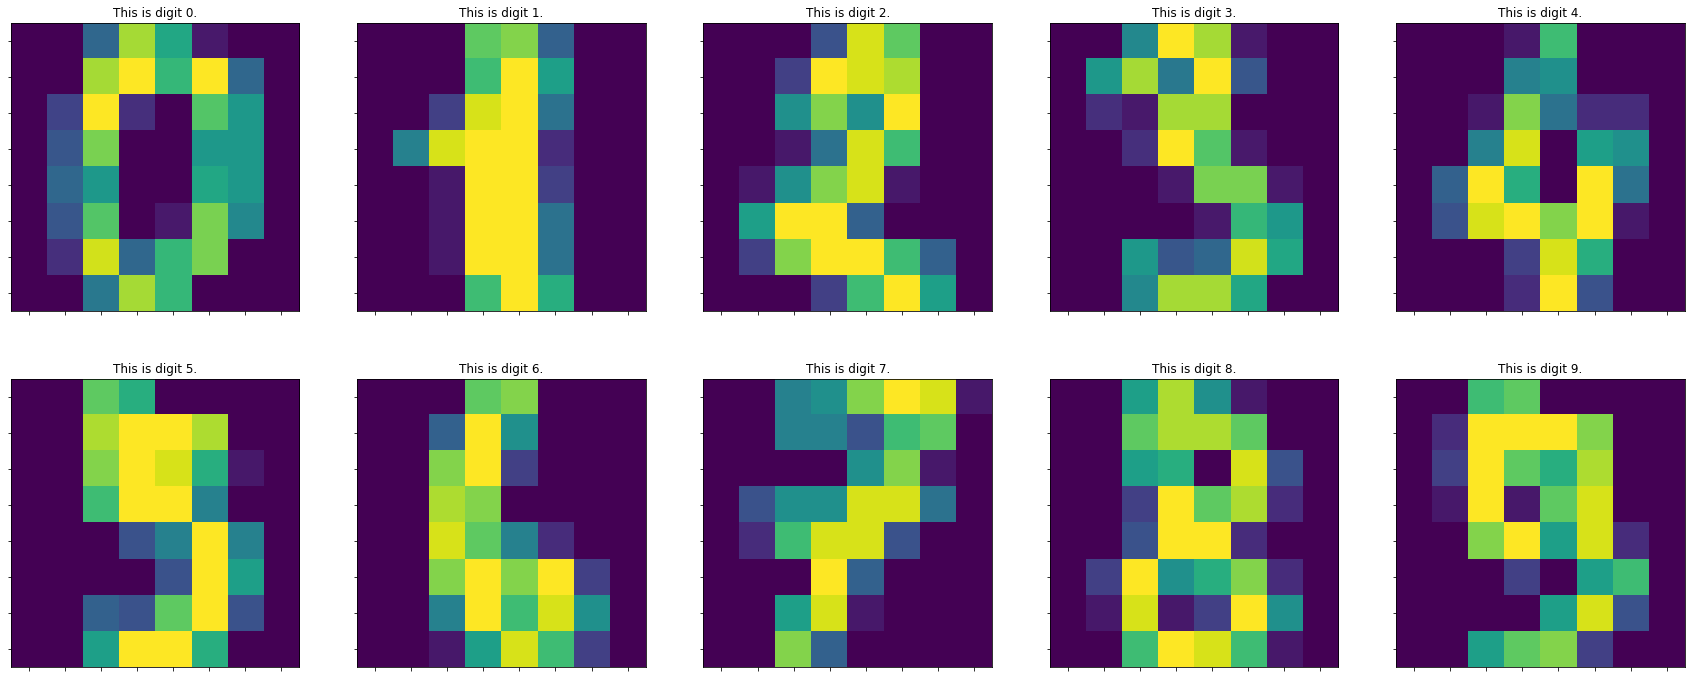

In [6]:
f, ax = plt.subplots(2,5,figsize=(30,12))
f.patch.set_color('white')
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(X.iloc[5*i+j].values.reshape(8,8))
        ax[i,j].set_title(f"This is digit {y[5*i+j]}.")
        ax[i,j].tick_params(labelbottom=False,labelleft=False)
plt.show()

## 2. Clustering and quality evaluation

**(2 points)** Implement the the KMeans algorithm. Use objective function $L = \sum_{i=1}^{n}|x_{i}-Z_{A(x_{i})}|^{2}$, where $Z_{A(x_{i})}$ is the center of the cluster corresponding to $x_{i}$ object.

In [7]:
from sklearn.exceptions import NotFittedError
from numpy.random import RandomState

In [130]:
class CustomKMeans:
    def __init__(self, n_clusters=2, max_iter=30, n_init=10, random_state=42):
        '''K-Means clustering.
        
        Args:
            n_clusters: int, default=2
                The number of clusters to be formed is also 
                the number of centroids to generate. 
            max_iter: int, default=300
                Maximum number of iterations of the k-means algorithm for a
                single run.
            n_init: int, default=10
                Number of time the k-means algorithm will be run with different
                centroid seeds. The final results will be the best output of
                n_init consecutive runs in terms of objective function.
            random_state: int, default=42
                Random state.
        '''
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.random_state = RandomState(seed=random_state)
        
    def calculate_distances_to_centroids(self, X, cluster_centers):
        """
        Returns (n, c) matrix where the element at position (i, j) 
        is the distance from i-th object to j-th centroid."""
        # <your code>

        I = X.shape[0]
        J = self.n_clusters
        D = np.empty(shape=(I,J))

        for i in range(I):
            for j in range(J):
                D[i][j] = ((X[i]-cluster_centers[j])**2).sum()

        return D

        pass
    
    def update_centroids(self, X, nearest_clusters):
        """
        Returns numpy array of shape (n_clusters, n_features) - 
        new clusters that are found by averaging objects belonging 
        to the corresponding cluster."""
        # <your code>

        n_samples = X.shape[0]
        for c in range(self.n_clusters):
            X_c = X[[np.allclose(nearest_clusters[i],self.cluster_centers_[c]) for i in range(n_samples)]]
            self.cluster_centers_[c] = X_c.mean(axis=0)

        pass
        
    def fit(self, X):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        """
        assert X.shape[0] >= self.n_clusters
        # <your code>

        X = X.to_numpy()
        n_samples = X.shape[0]
        results, dists  = [], []
        for n in range(self.n_init):
            self.cluster_centers_ = X[self.random_state.choice(np.arange(n_samples), size=self.n_clusters, replace=False)]
            for __ in range(self.max_iter):
                D = self.calculate_distances_to_centroids(X=X, cluster_centers=self.cluster_centers_)
                nearest_clusters = []
                for i in np.argmin(D,axis=1):
                    nearest_clusters.append(self.cluster_centers_[i])
                nearest_clusters = np.array(nearest_clusters)
                self.update_centroids(X=X, nearest_clusters=nearest_clusters)
            results.append(self.cluster_centers_)
            D = self.calculate_distances_to_centroids(X=X, cluster_centers=self.cluster_centers_)
            nearest_clusters = []
            for i in np.argmin(D,axis=1):
                nearest_clusters.append(self.cluster_centers_[i])
            nearest_clusters = np.array(nearest_clusters)
            dists.append(((X-nearest_clusters)**2).sum())
        
        self.cluster_centers_ = results[np.argmin(dists)]
        self.distance = min(dists)
        
        return self
            
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted cluster labels.
        """
        if hasattr(self, 'cluster_centers_'):
            # <your code>

            D = self.calculate_distances_to_centroids(X=X.to_numpy(), cluster_centers=self.cluster_centers_)
            result = np.argmin(D,axis=1)

            return result

            pass
        else: 
            raise NotFittedError("CustomKMeans instance is not fitted yet")

**(1 points)** Get the `X` array partition into 10 clusters. Visualize the centers of clusters.
- We will assume that the center of the cluster is average value of all observations belonging to the cluster.
- The cluster centers should have the same shape as our observations (64). So you have to average the points across the rows.

In [131]:
ckmeans = CustomKMeans(n_clusters=10,max_iter=10,n_init=10)
ckmeans.fit(X)
y_pred = ckmeans.predict(X)

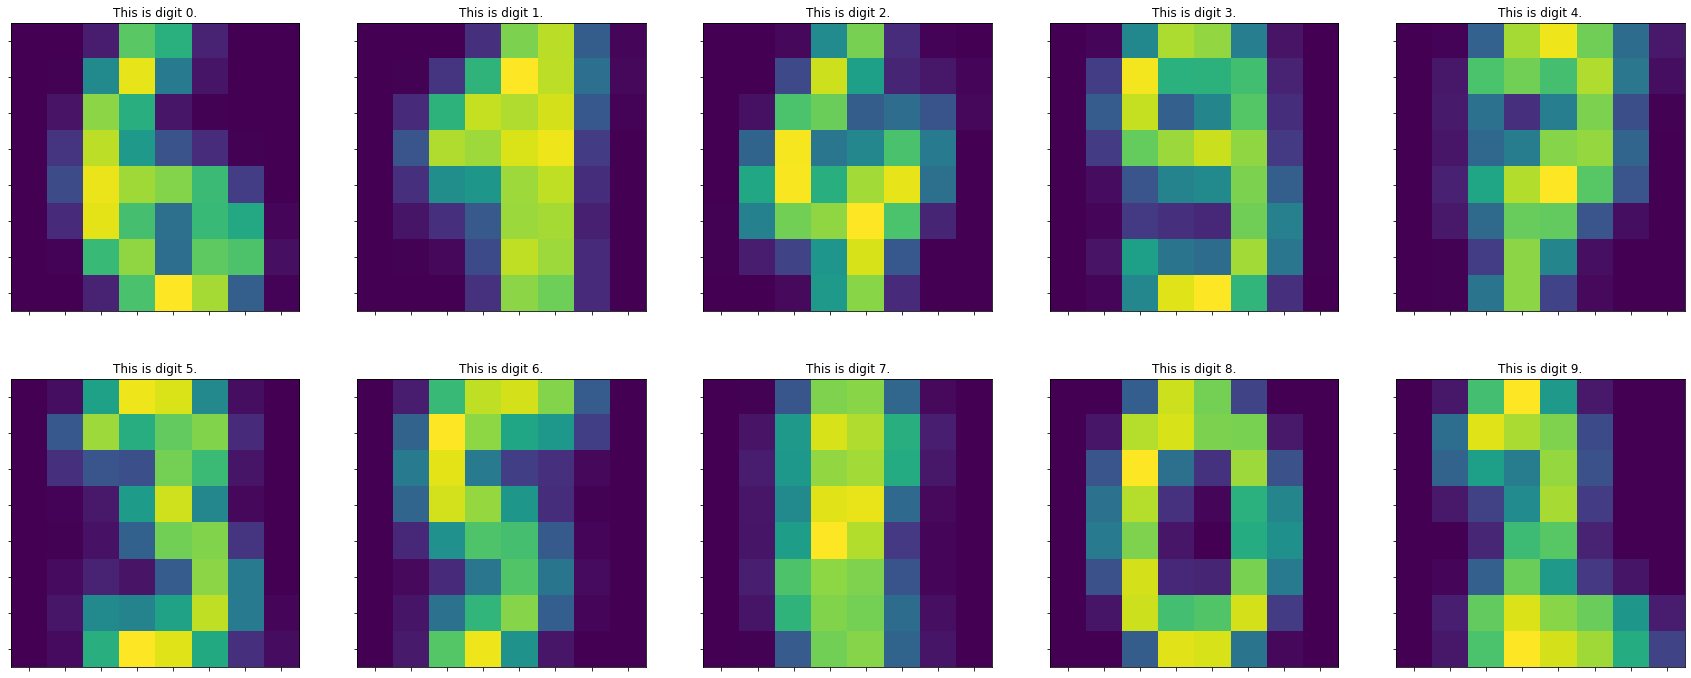

In [133]:
f, ax = plt.subplots(2,5,figsize=(30,12))
f.patch.set_color('white')
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(ckmeans.cluster_centers_[5*i+j].reshape(8,8))
        ax[i,j].set_title(f"This is digit {5*i+j}.")
        ax[i,j].tick_params(labelbottom=False,labelleft=False)
plt.show()

Изоражения центров кластеров переставлены относительно настоящих наименований, поэтому изменим результаты в соответствии с изображениями.

In [134]:
y_pred_ = pd.DataFrame(y_pred).replace({0:6,1:1,2:4,3:9,4:7,5:3,6:5,7:8,8:0,9:2})[0].to_numpy()

In [135]:
custom_kmeans_labels = y_pred_
assert custom_kmeans_labels.shape == (1797,)

**(0.5 points)** Experiment with `max_iter` and `n_init` parameters. Look at the range of values of the objective function, it's best values, at what parameters and how often they are achieved.

Обучение - медленный процесс, поэтому ограничимся небольшими диапазонами.

Изменение параметра `max_iter` (`n_inits=5`):

In [139]:
dists = []
max_iters = np.arange(1,10)
for n in max_iters:
    ckmeans = CustomKMeans(n_clusters=10,max_iter=n,n_init=5)
    ckmeans.fit(X)
    dists.append(ckmeans.distance)

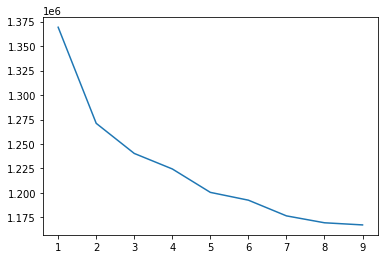

In [140]:
plt.plot(max_iters, dists)
plt.show()

Изменение параметра `n_inits` (`max_iter=5`):

In [141]:
dists = []
n_inits = np.arange(1,10)
for n in n_inits:
    ckmeans = CustomKMeans(n_clusters=10,max_iter=5,n_init=n)
    ckmeans.fit(X)
    dists.append(ckmeans.distance)

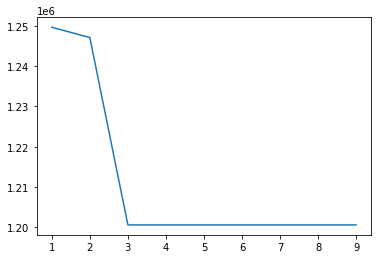

In [142]:
plt.plot(n_inits, dists)
plt.show()

Количества запусков более 3 раз не делают кластеризацию лучше.

Это утверждение может быть верным только для `max_iter=5`. Прочие случаи не рассматриваются.

Now we will use two popular algorithms: hierarchical clustering and $K$-means clustering. These and other algorithms are available in the `scikit-learn` module in the `cluster` submodule. Hierarchical clustering is called `AgglomerativeClustering`, and the $K$-means method is called `KMeans`.

**(0.5 points)** Use each of the two methods: hierarchical clustering and KMeans. Get the `X` array partition into 10 clusters.

- Note that `AgglomerativeClustering` does not have a `predict` method, so you can either use the `fit_predict` method or use the `fit` method and then look at the `labels_` attribute of the class instance.
- Kmeans performs multiple runs (default 10) with random centers and then returns the best partition in terms of average distance within the clusters. You can increase the number of runs to improve the quality of predictions in the `i_init` parameter.

In [154]:
kmeans = KMeans(n_clusters=10)
kmeans.fit(X)

ac = AgglomerativeClustering(n_clusters=10)
ac.fit(X)

AgglomerativeClustering(n_clusters=10)

In [147]:
hierarchical_labels = ac.labels_
kmeans_labels = kmeans.labels_

In [148]:
assert hierarchical_labels.shape == (1797,)
assert kmeans_labels.shape == (1797,)

**(0.5 points)** Visualize the centers of clusters obtained by both methods.

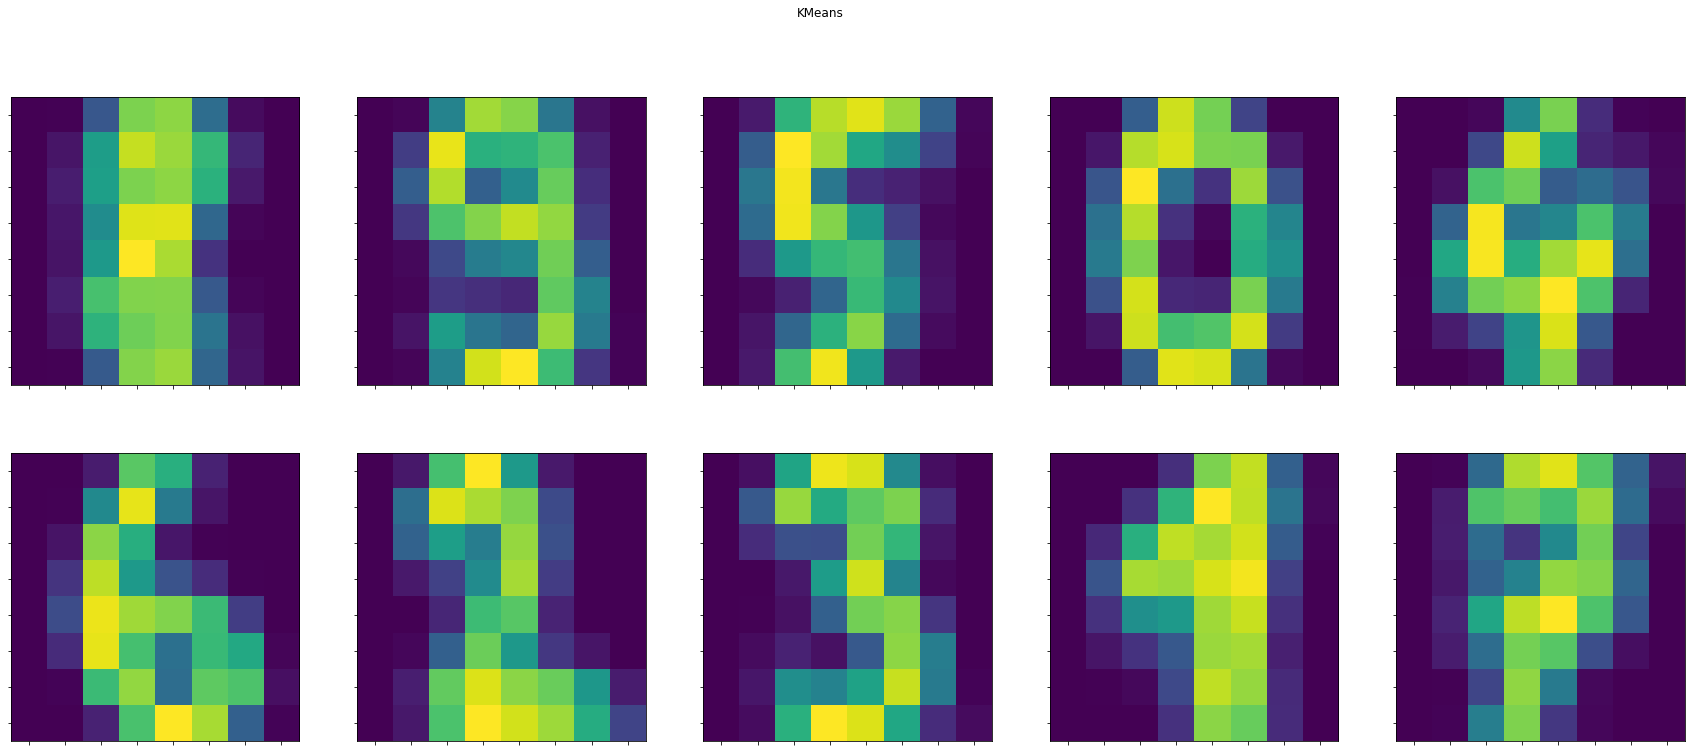

In [151]:
f, ax = plt.subplots(2,5,figsize=(30,12))
f.patch.set_color('white')
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(kmeans.cluster_centers_[5*i+j].reshape(8,8))
        ax[i,j].tick_params(labelbottom=False, labelleft=False)
plt.suptitle('KMeans')
plt.show()

In [160]:
y_predict = ac.fit_predict(X)
clf = NearestCentroid()
clf.fit(X, y_predict)

NearestCentroid()

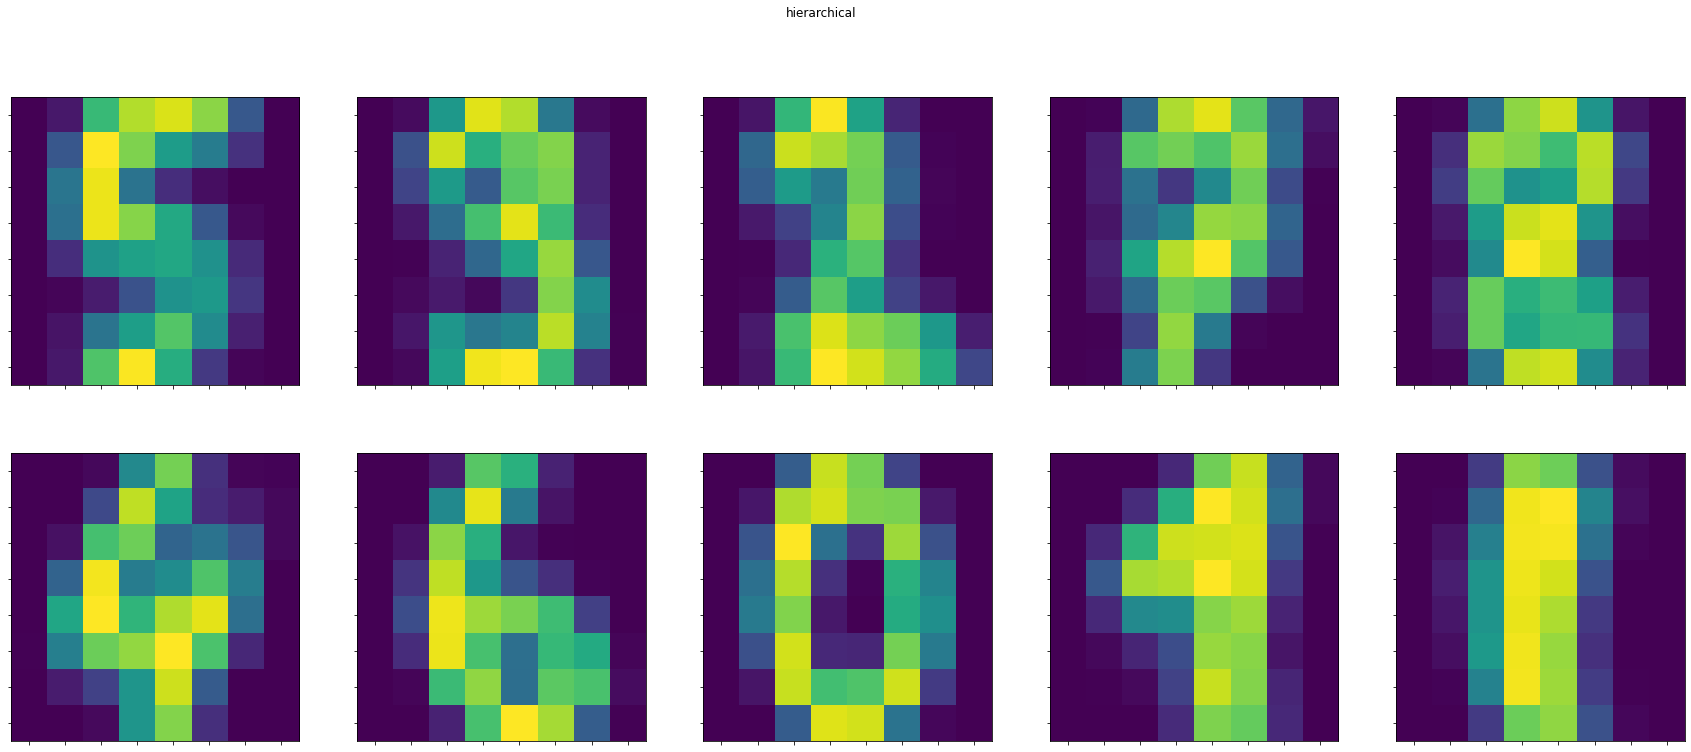

In [161]:
f, ax = plt.subplots(2,5,figsize=(30,12))
f.patch.set_color('white')
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(clf.centroids_[5*i+j].reshape(8,8))
        ax[i,j].tick_params(labelbottom=False, labelleft=False)
plt.suptitle('hierarchical')
plt.show()

In a situation where the true number of classes is unknown, we can select it by maximazing some metric.

When we can set some distance function between our observations, we can consider the `silhouette` distance as a function of measuring the quality of the clustering. Let's show how it is calculated:

Let $X$ – set of observations, $M \subset X$ – one of the clusters obtained as a result of clustering process, $\rho$ – some metric on $X$. Let's choose one observation $x \in M$. Denote $a(x)$ as the average distance from $x$ to  $x'$ points from the same cluster:
$$
a(x) = \frac{1}{|M| - 1} \sum_{x' \in M,\, x' \ne x} \rho(x,\, x')
$$

Denote $b(x)$ as minimun of average distances from $x$ to $x''$ from some other cluster $N$:
$$
b(x) = \min_{N \ne M} \frac{1}{|N|} \sum_{x'' \in N} \rho(x,\, x'')
$$

The silhouette is difference between a(x) and b(x), normalized to $[-1, \, 1]$ and averaged over all observations:
$$
\frac{1}{|X|} \sum_{x \in X} \frac{b(x) - a(x)}{\max(a(x),\, b(x))}
$$

The implementation of this metric in the `scikit-learn` is the `silhouette_score` function from the `metrics` submidule.

**(0.75 point)** For each $K$ between 2 and 20 inclusive, partition of the array $X$ into $K$ clusters using both methods. Calculate the silhouette score and visualize it for both methods on the same plot ($K$ on the $x$ axis and silhouette score on the $y$ axis). Sign the axes and make a legend.

In [226]:
K = np.arange(2,21)
kmeans_score, ac_score = [], []
for k in K:
    kmeans, ac = KMeans(n_clusters=k), AgglomerativeClustering(n_clusters=k)
    kmeans_score.append(silhouette_score(X,kmeans.fit_predict(X)))
    ac_score.append(silhouette_score(X,ac.fit_predict(X)))

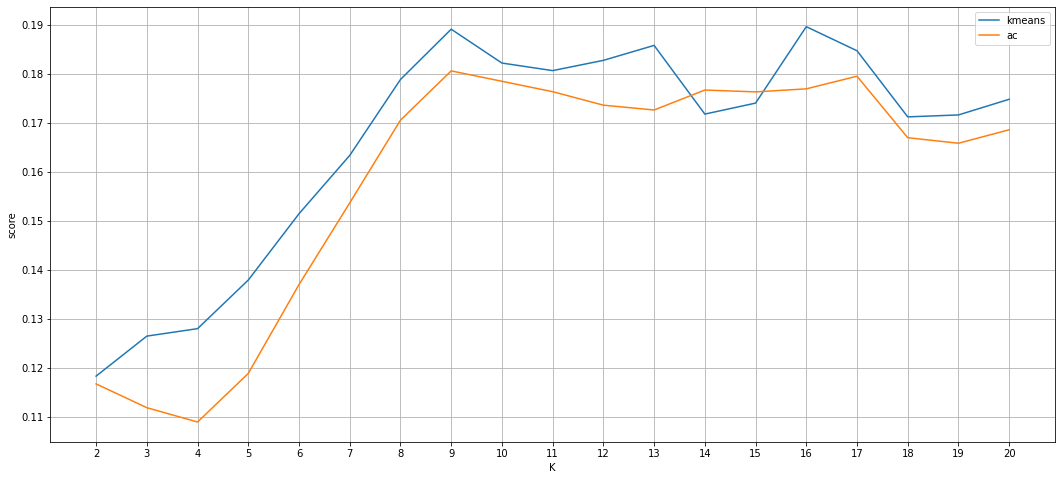

In [227]:
f, a = plt.subplots(figsize=(18,8))
a.set_xticks(K)
a.grid()
plt.plot(K,kmeans_score,label='kmeans')
plt.plot(K,ac_score,label='ac')
plt.legend()
a.set_xlabel('K')
a.set_ylabel('score')
plt.show()

When we know the true clustering labels, the clustering result can be compared to them using measures such as `homogeneity`, `completeness` and their harmonic mean - $V$-score. The definitions of these quantities are rather bulky and are based on the [entropy of the probability distribution](https://ru.wikipedia.org/wiki/Информационная_энтропия). Details are given in [this article](http://aclweb.org/anthology/D/D07/D07-1043.pdf). In practice, it's enough to know that `homogeneity`, `completeness` and $V$-score are in the range from 0 and 1, and the more, the better.

Since we know what digit each image is (`y` array), we can compare the clustering results to it using the measures listed above.

**(0.5 points)** Repeat the previous task using $V$-measure instead of silhouette.

In [228]:
K = np.arange(2,21)
kmeans_score, ac_score = [], []
for k in K:
    kmeans, ac = KMeans(n_clusters=k), AgglomerativeClustering(n_clusters=k)
    kmeans_score.append(v_measure_score(y,kmeans.fit_predict(X)))
    ac_score.append(v_measure_score(y,ac.fit_predict(X)))

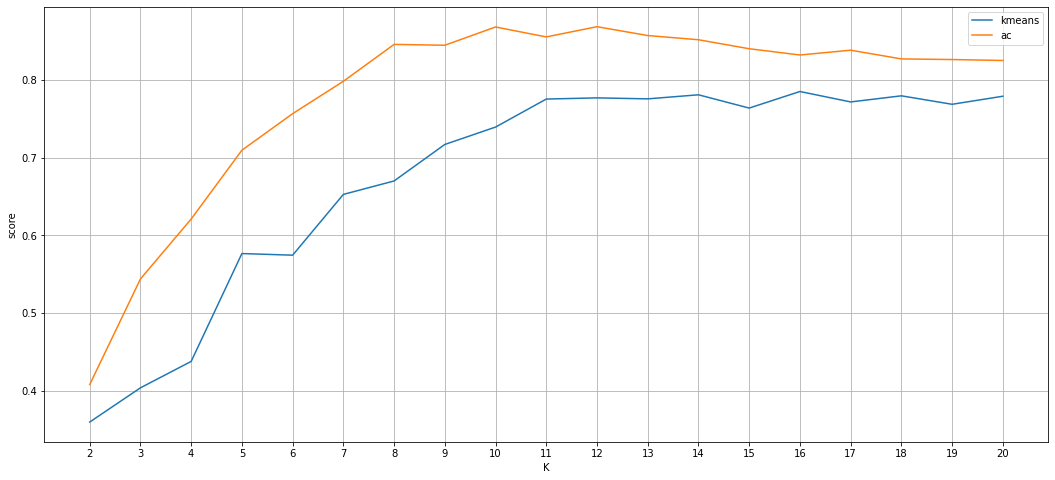

In [229]:
f, a = plt.subplots(figsize=(18,8))
a.set_xticks(K)
a.grid()
plt.plot(K,kmeans_score,label='kmeans')
plt.plot(K,ac_score,label='ac')
plt.legend()
a.set_xlabel('K')
a.set_ylabel('score')
plt.show()

## 3. Feature space dimensionality reduction

In some cases, especially when there are a large number of features, when not all of them are informative, and some of them are correlated, it can be useful to reduce the dimension of the feature space. This mean that instead of $d$ original features, we will go to $d'\ll d$ new ones. And if earlier our data were presented in the form of an $n×d$ matrix, then it will presented as a $n×d'$.

There are two popular dimensionality reduction approaches:
- select new features from existing features;
- extract the new features by transforming old ones, for example, by making $d'$ different linear combinations of columns of an $n×d$ matrix.

One widely used dimensionality reduction technique is the Singular Value Decomposition (SVD). This method allows you to construct any number $d'\leq d$ of new features in such a way that they are the most informative (in some sense).

The `scikit-learn` module has several implementations of singular value decomposition. We will use the `TruncatedSVD` class from the `decomposition` submodule.

**Note:** The singular value decomposition of the matrix $M$ is usually written as $M=U \Sigma V^{*}$. `TruncatedSVD`, in turn, returns only the $d'$ first columns of the matrix $U$.

**(0.75 point)** Perform a singular value decomposition of the $X$ matrix, leaving 2, 5, 10, 20 features. In each case, perform hierarchical clustering and $K$-Means clustering (take the number of clusters equal to 10). Calculate the silhouette and $V$-score and compare them to corresponding values obtained from the original data.

**Note**: It is not valid to compare the silhouette calculated with different metrics. Even if we use the same metric function when calculating the distance between points in the data, after applying dimensionality reduction or other data transformations, we will (not always) get different silhouette scores. Therefore, after training the clustering algorithm, to compare the result of clustering, you need to calculate the silhouette on the original data.

In [281]:
ns = (2, 5, 10, 20)
kmeans_sscore, ac_sscore, kmeans_vscore, ac_vscore = [], [], [], []
for n in ns:
    X_trans = TruncatedSVD(n_components=n).fit_transform(X)
    kmeans, ac = KMeans(n_clusters=10), AgglomerativeClustering(n_clusters=10)
    kmeans_sscore.append(silhouette_score(X,kmeans.fit_predict(X_trans)))
    ac_sscore.append(silhouette_score(X,ac.fit_predict(X_trans)))
    kmeans, ac = KMeans(n_clusters=10), AgglomerativeClustering(n_clusters=10)
    kmeans_vscore.append(v_measure_score(y,kmeans.fit_predict(X_trans)))
    ac_vscore.append(v_measure_score(y,ac.fit_predict(X_trans)))

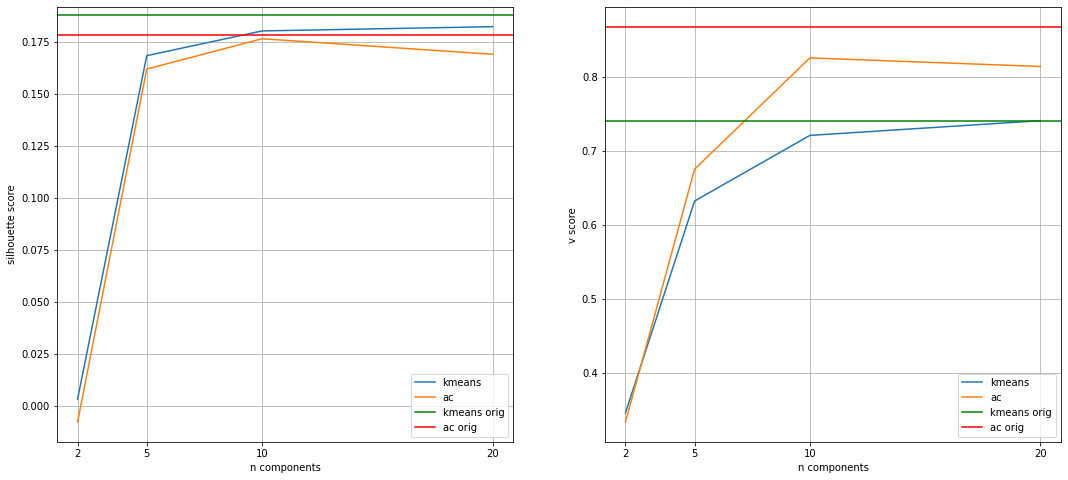

In [282]:
f, ax = plt.subplots(1,2,figsize=(18,8))
ax[0].set_ylabel('silhouette score')
ax[1].set_ylabel('v score')
ax[0].plot(ns,kmeans_sscore,label='kmeans')
ax[0].plot(ns,ac_sscore,label='ac')
ax[0].axhline(silhouette_score(X,KMeans(n_clusters=10).fit_predict(X)),label='kmeans orig',color='green')
ax[0].axhline(silhouette_score(X,AgglomerativeClustering(n_clusters=10).fit_predict(X)),label='ac orig',color='red')
ax[1].plot(ns,kmeans_vscore,label='kmeans')
ax[1].plot(ns,ac_vscore,label='ac')
ax[1].axhline(v_measure_score(y,KMeans(n_clusters=10).fit_predict(X)),label='kmeans orig',color='green')
ax[1].axhline(v_measure_score(y,AgglomerativeClustering(n_clusters=10).fit_predict(X)),label='ac orig',color='red')
for a in ax:
    a.set_xticks(ns)
    a.grid()
    a.set_xlabel('n components')
    a.legend()
plt.show()

Another popular dimensionality reduction approach that is useful for working with images is t-distributed stochastic neighbor embeddings, abbreviated `tSNE`. Unlike singular value decomposition, this it is non-linear transformation. It's main idea is to map points from a space of dimension `d` to another space of dimension 2 or 3 in such a way that the distances between points are mostly preserved. Mathematical details can be found, for example, [here](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding).

The implementation of `tSNE` in the `scikit-learn` library is the `TSNE` class in the `manifold` submodule.

**Note:** In recent years [UMAP](https://github.com/lmcinnes/umap) is often used istead of `tSNE`. It is a faster algorithm with similar properties. We don't ask you to use `UMAP` because it requires you to install another dependency, the `umap-learn` library. Those who wish can perform the following task using `UMAP`.

**(0.5 points)** Perform a tSNE-transform of the `X` matrix, leaving 2 features. Visualize the obtained data in the form of a scatter plot form: the first feature on the horizontal axis, and the second one the vertical axis. Color the points according to the digits they belong to.

- The `c` parameter in the plt.scatter function is responsible for the color of the points. Pass the true labels to it.

In [261]:
tsne = TSNE()
X_trans = tsne.fit_transform(X)

D:\Python 3.9\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
D:\Python 3.9\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


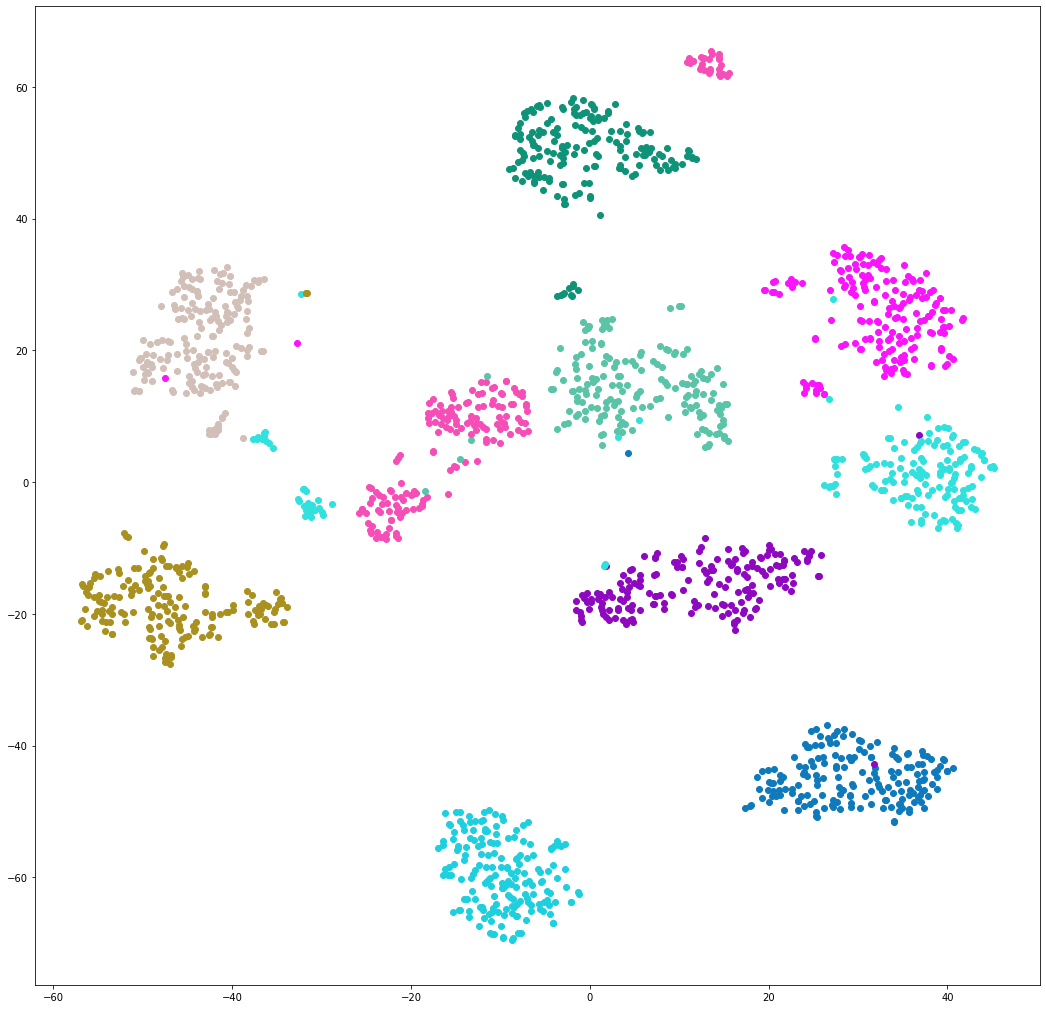

In [280]:
colors = [tuple(np.random.uniform(size=3)) for _ in range(10)]
plt.figure(figsize=(18,18))
for i in range(X.shape[0]):
    plt.scatter(X_trans[i,0],X_trans[i,1],color=colors[y[i]])

**(0.5 points)** From the data transformed using the tSNE, perform hierarchical clustering and $K$-means clustering (take the number of clusters equal to 10). Calculate the silhouette and the $V$-score and compare them to corresponding values obtained from the original data.

In [283]:
kmeans, ac = KMeans(n_clusters=10), AgglomerativeClustering(n_clusters=10)
kmeans_sscore = silhouette_score(X, kmeans.fit_predict(X_trans))
ac_sscore = silhouette_score(X, ac.fit_predict(X_trans))
kmeans, ac = KMeans(n_clusters=10), AgglomerativeClustering(n_clusters=10)
kmeans_vscore = v_measure_score(y, kmeans.fit_predict(X_trans))
ac_vscore = v_measure_score(y, ac.fit_predict(X_trans))
kmeans, ac = KMeans(n_clusters=10), AgglomerativeClustering(n_clusters=10)
kmeans_sscore_orig = silhouette_score(X, kmeans.fit_predict(X))
ac_sscore_orig = silhouette_score(X, ac.fit_predict(X))
kmeans, ac = KMeans(n_clusters=10), AgglomerativeClustering(n_clusters=10)
kmeans_vscore_orig = v_measure_score(y, kmeans.fit_predict(X))
ac_vscore_orig = v_measure_score(y, ac.fit_predict(X))

In [288]:
pd.DataFrame([
    ['orig',kmeans_sscore_orig,ac_sscore_orig,kmeans_vscore_orig,ac_vscore_orig],
    ['tSNE',kmeans_sscore,ac_sscore,kmeans_vscore,ac_vscore]
    ], columns=['type','kmeans sil','ac sil','kmeans v','ac v']).set_index('type')

,kmeans sil,ac sil,kmeans v,ac v
type,,,,
orig,0.182231,0.178497,0.744777,0.868170
tSNE,0.182270,0.169133,0.741871,0.814388


**(0.25 points)** Choose the best partition (in terms of silhouette or $V$-score) and visualize the centers of clusters with images. Did you managed to make each digit correspond to one center of the cluster?

Лучшая комбинация по `silhouette` : `kmeans+tSNE`.

D:\Python 3.9\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
D:\Python 3.9\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


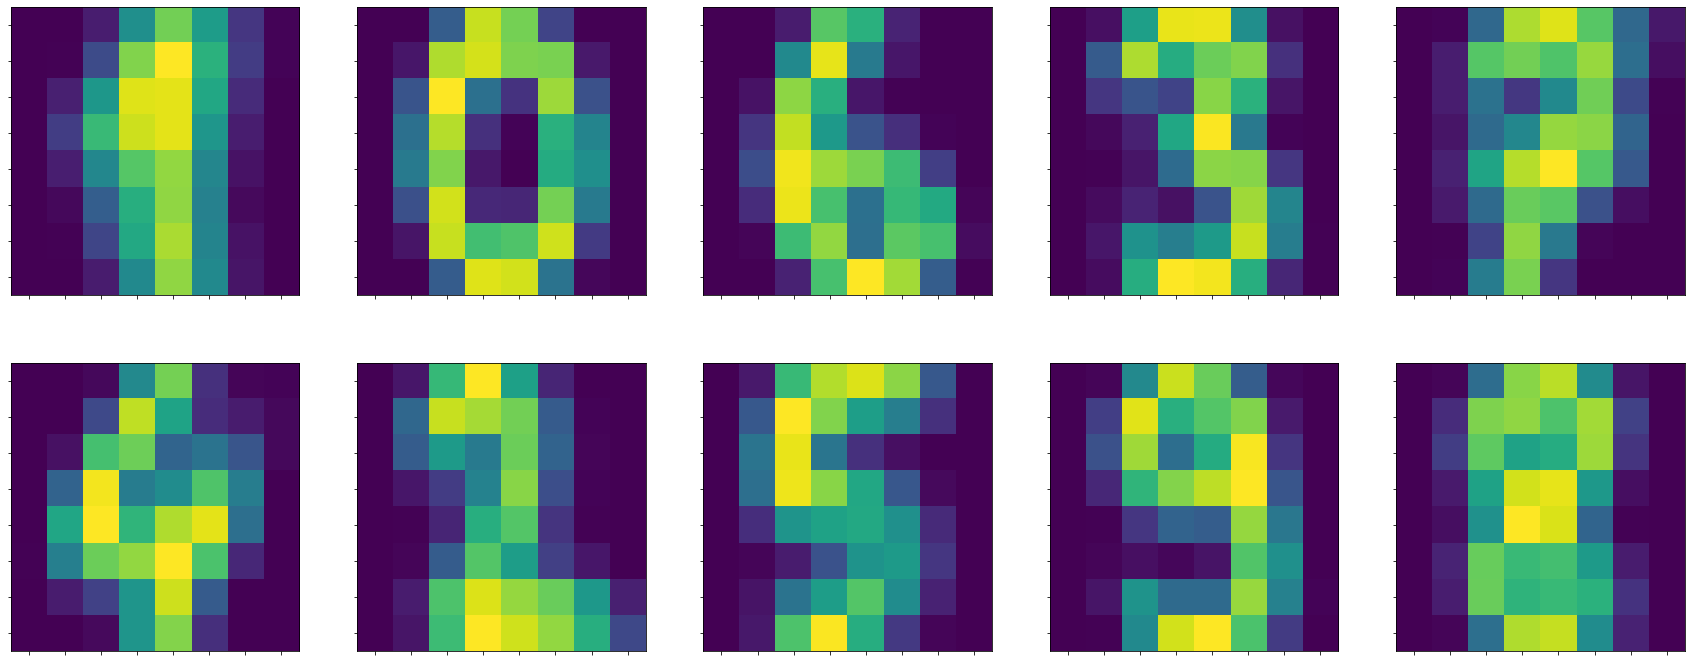

In [293]:
kmeans = KMeans(n_clusters=10)
y_predict = kmeans.fit_predict(TSNE().fit_transform(X))
clf = NearestCentroid()
clf.fit(X, y_predict)

f, ax = plt.subplots(2,5,figsize=(30,12))
f.patch.set_color('white')
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(clf.centroids_[5*i+j].reshape(8,8))
        ax[i,j].tick_params(labelbottom=False, labelleft=False)
plt.show()

Лучшая комбинация по `V-score` : `ac orig`.

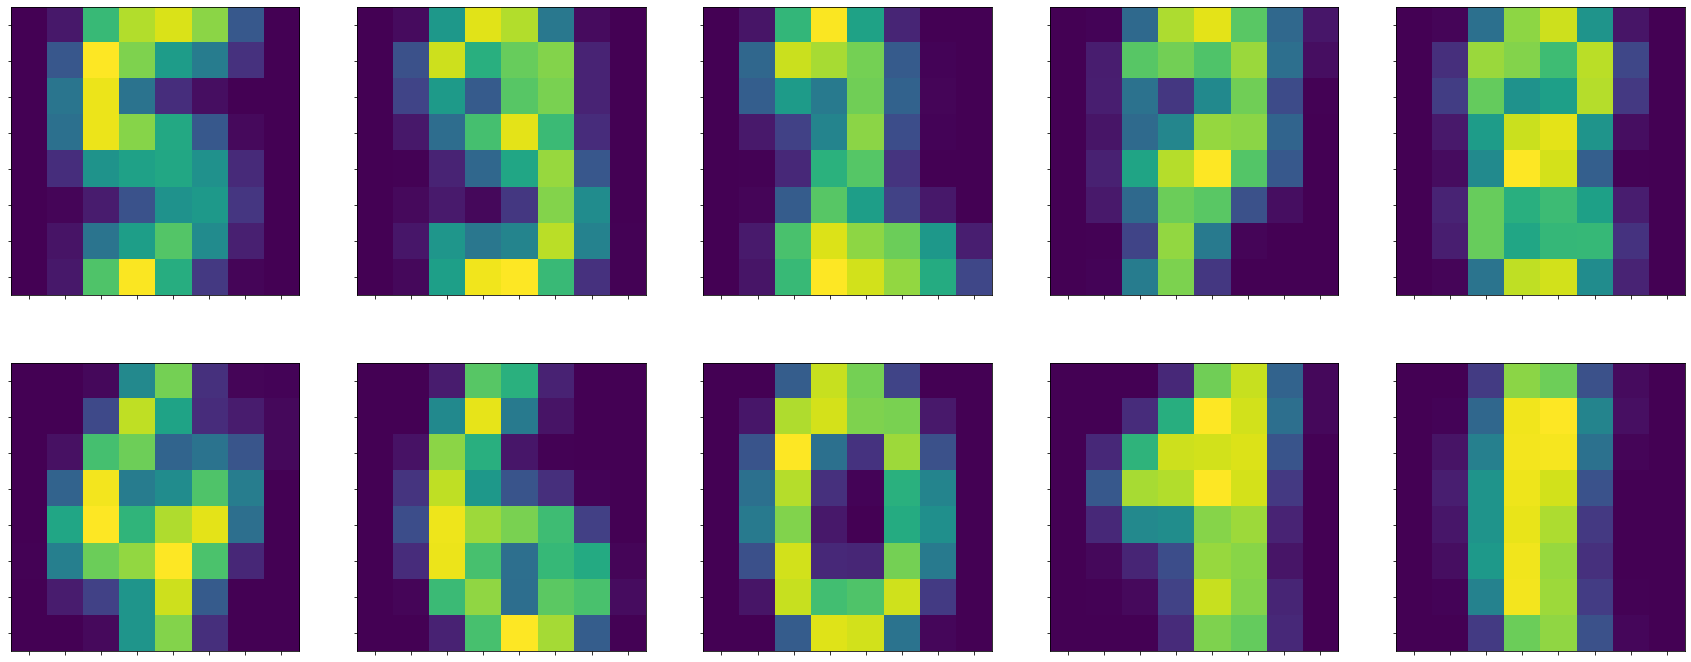

In [292]:
ac = AgglomerativeClustering(n_clusters=10)
y_predict = ac.fit_predict(X)
clf = NearestCentroid()
clf.fit(X, y_predict)

f, ax = plt.subplots(2,5,figsize=(30,12))
f.patch.set_color('white')
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(clf.centroids_[5*i+j].reshape(8,8))
        ax[i,j].tick_params(labelbottom=False, labelleft=False)
plt.show()

## 4. Results and bonus part

Write in free form what conclusions you made after completing this assignment. Answer the following questions:

**(0.5 points)** Which algorithm gives more meaningful results - hierarchical clustering or $K$- means clustering. Does it depend on the algorithm settings or on the quality evaluation method?

Если ориентироваться на `silhouette`, лучше себя показывает `K-means` $(0.182231)$.

Если ориентироваться на `V-score`, лучше себя показывает `hierarchical` $(0.868170)$.

Говоря об исследовании поведение `K-means`, можно полагать, что: эффективность растет с увеличением `max_iter`, однако этот рост замедляется, и начиная с некоторого значения увеличение не является эффективным; существует предельное эффективное значение `n_iter`, после которого не происходит улучшения модели.

**(0.5 points)** Imagine the situation where after hierarchical clustering, you need to cluster new data in the same way without retraining the model. Suggest a method how you will do it and how you will measure the quality of clustering of new data.

Для каждого нового элемента можно найти ближайшего (по использованной метрике) оригинального соседа и приписать ему тот же кластер. Эту идею можно обобщить, если пересмотреть k ближайших оригинальных соседей и присвоить кластер, избранный после проведения взвешенного по расстоянию голосования.

Можно также создать некоторое правило, согласно которому пространство разобъется на подобласти и попадание в одну из них нового элемента будет означать принадлежность соответствующему кластеру.

Оценить качество кластеризации новых данных можно по суммарным расстояниям до центров соответсвующих кластеров.

Предложенные методы подействуют адекватно, если новые данный окажутся подобны оригинальным, на которых строилась модель, если предполагается та же система кластеров. Непонятно, что делать, если новые данные сами объективно образуют отдельный кластер или в принципе не имеют ничего общего с имеющейся кластеризацией.

Заподозрить новый кластер можно при помощи сравнения суммы растояний от элементов до центров соповставленных кластеров по принципам выше и суммы расстояний от элементов до их собственного центра, как если бы они образовали собственный кластер.

**(0.5 points)** Does dimensionality reduction improve clustering results?

Исследование выше показало, что уменьшение размерности в использованных диапазонах не привело к улучшению модели. Однако этот прием можно использовать для облегчения/ускорения вычислений. Видно, что понижение размерности до, например, $10$, не слишком сильно ухудшает модель, но уменьшает объем перерабатываемой информации более чем в 6 раз.

**(0.5 points)** How to evaluate the quality of dimensional reduction? Suggest at least 2 options.

**(Bonus 2 points)** Load the [MNIST Handwritten Digits](http://yann.lecun.com/exdb/mnist) dataset. You can also do it with `scikit-learn` as explained [here](https://stackoverflow.com/a/60450028). Explore the data and try to cluster it using different approaches. Compare results of these approaches using the silhouette and the $V$-score.

In [7]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

`AgglomerativeClustering` не выдерживает весь объем данных, поэтому возьмем для рассмотрения первые 10 тыс. значений.

In [88]:
X_ = X.to_numpy()[:10000]
y_ = y.to_numpy()[:10000].astype(int)

Обзор данных

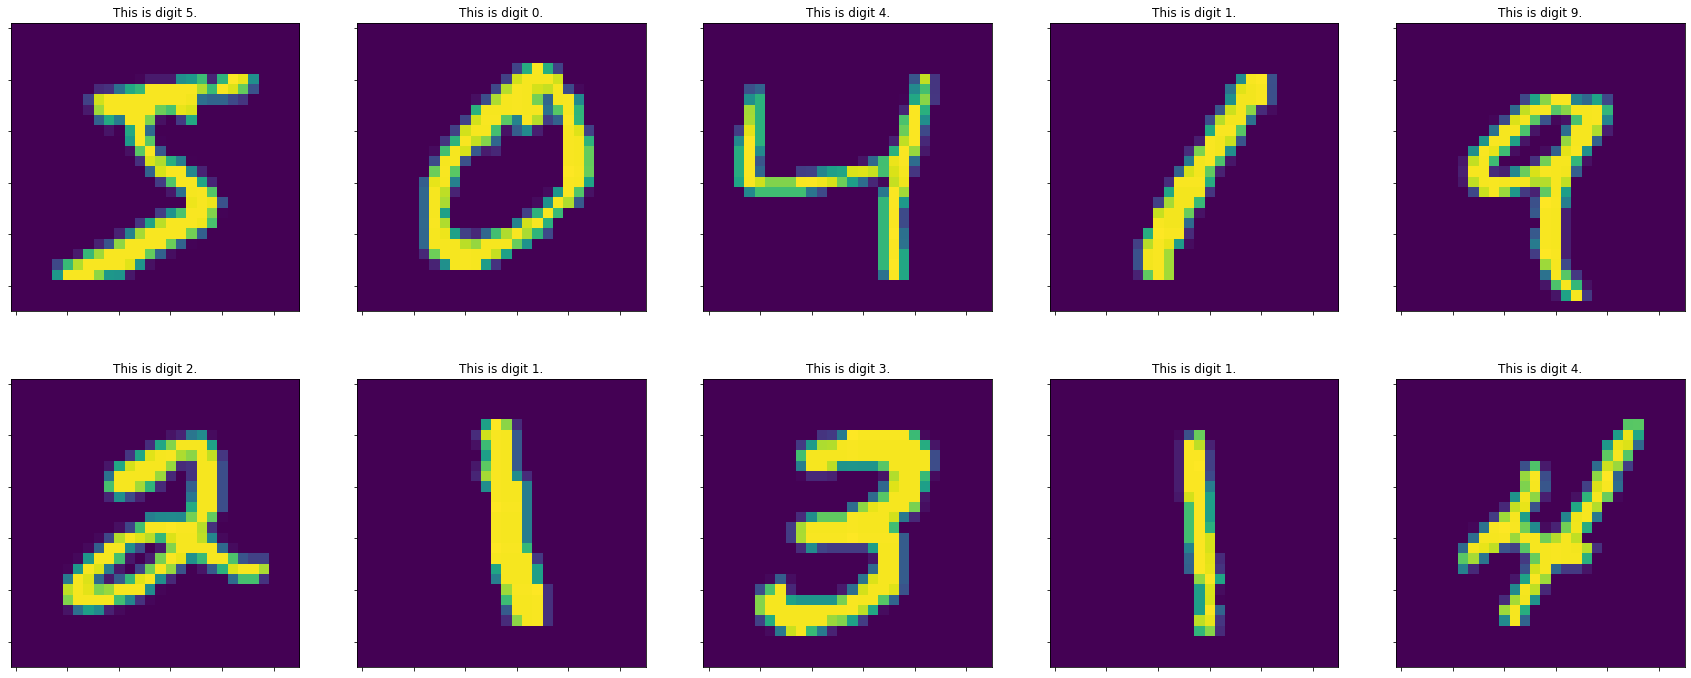

In [89]:
f, ax = plt.subplots(2,5,figsize=(30,12))
f.patch.set_color('white')
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(X_[5*i+j].reshape(28,28))
        ax[i,j].set_title(f"This is digit {y_[5*i+j]}.")
        ax[i,j].tick_params(labelbottom=False,labelleft=False)
plt.show()

In [90]:
kmeans = KMeans(n_clusters=10)
y_pred_kmeans = kmeans.fit_predict(X_)

In [91]:
ac = AgglomerativeClustering(n_clusters=10)
y_pred_ac = ac.fit_predict(X_)

Центры кластеров модели `KMeans`

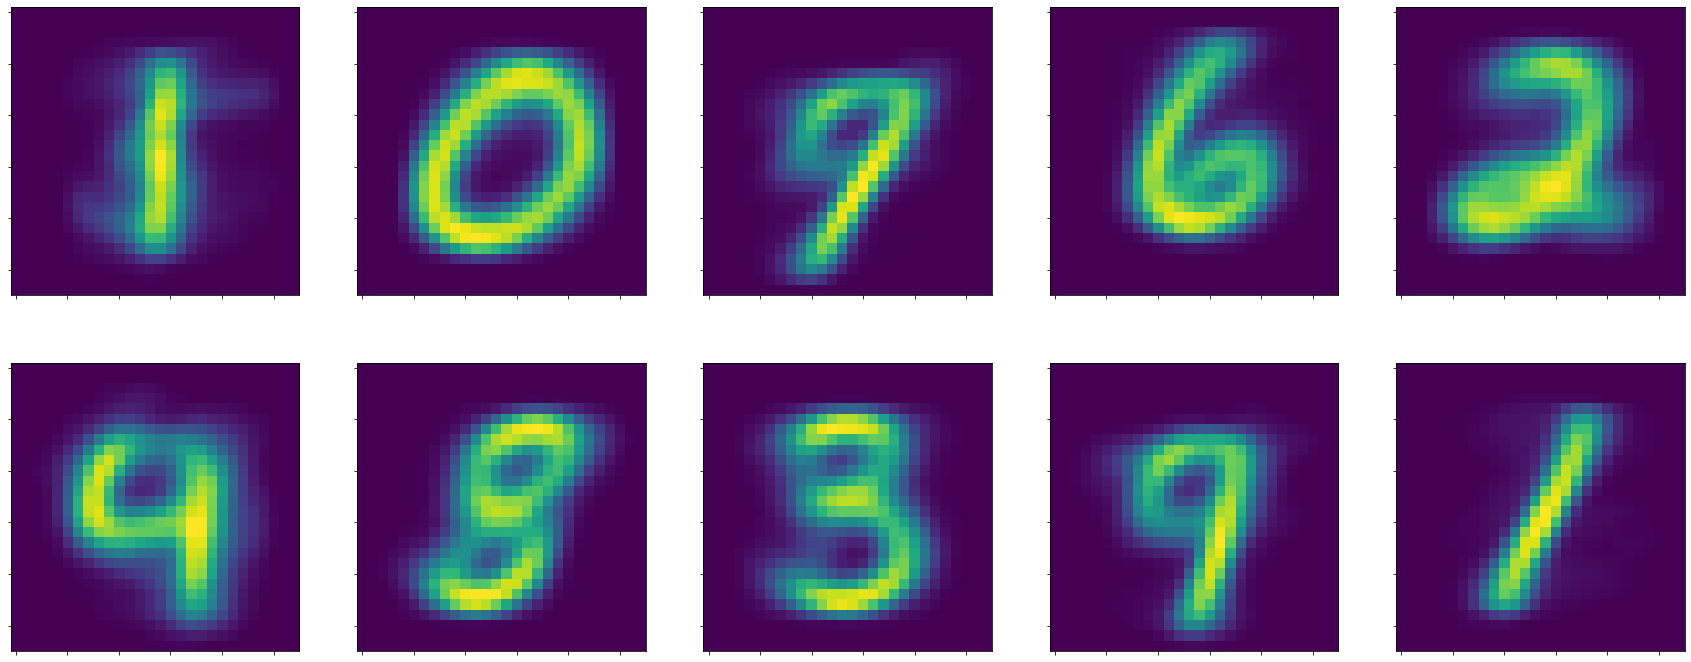

In [92]:
f, ax = plt.subplots(2,5,figsize=(30,12))
f.patch.set_color('white')
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(kmeans.cluster_centers_[5*i+j].reshape(28,28))
        ax[i,j].tick_params(labelbottom=False, labelleft=False)
plt.show()

Центры кластеров модели `AgglomerativeClustering`

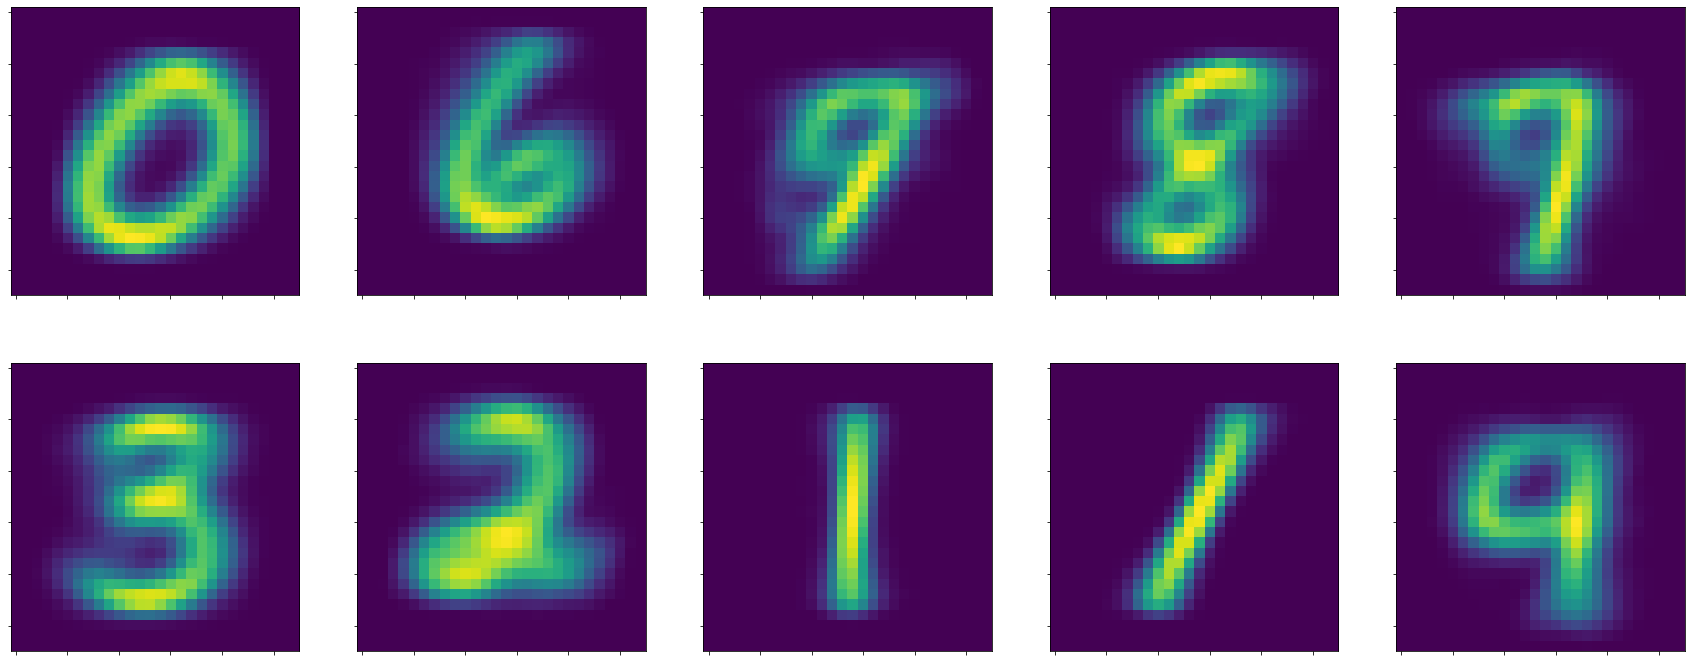

In [93]:
clf = NearestCentroid()
clf.fit(X_, y_pred_ac)

f, ax = plt.subplots(2,5,figsize=(30,12))
f.patch.set_color('white')
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(clf.centroids_[5*i+j].reshape(28,28))
        ax[i,j].tick_params(labelbottom=False, labelleft=False)
plt.show()

Метрики на оригинальных данных

In [94]:
kmeans_silhouette_score = silhouette_score(X_,y_pred_kmeans)
kmeans_v_measure_score = v_measure_score(y_, y_pred_kmeans)
ac_silhouette_score = silhouette_score(X_,y_pred_ac)
ac_v_measure_score = v_measure_score(y_, y_pred_ac)

pd.DataFrame([
    ['KMeans', kmeans_silhouette_score, kmeans_v_measure_score],
    ['Agglomerative', ac_silhouette_score, ac_v_measure_score]
], columns=['model','silhouette_score','v_measure_score']).set_index('model')

,silhouette_score,v_measure_score
model,,
KMeans,0.062269,0.477545
Agglomerative,0.032955,0.662548


In [95]:
ns = np.arange(1,41,3)
kmeans_sscore, ac_sscore, kmeans_vscore, ac_vscore = [], [], [], []
for n in ns:
    X_trans = TruncatedSVD(n_components=n).fit_transform(X_)
    kmeans, ac = KMeans(n_clusters=10), AgglomerativeClustering(n_clusters=10)
    kmeans_sscore.append(silhouette_score(X_,kmeans.fit_predict(X_trans)))
    ac_sscore.append(silhouette_score(X_,ac.fit_predict(X_trans)))
    kmeans, ac = KMeans(n_clusters=10), AgglomerativeClustering(n_clusters=10)
    kmeans_vscore.append(v_measure_score(y_,kmeans.fit_predict(X_trans)))
    ac_vscore.append(v_measure_score(y_,ac.fit_predict(X_trans)))

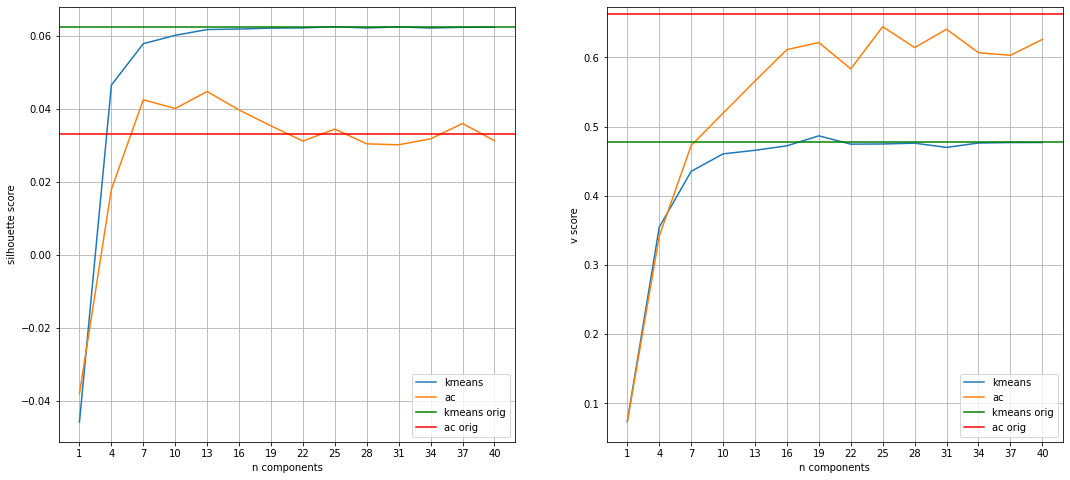

In [96]:
f, ax = plt.subplots(1,2,figsize=(18,8))
ax[0].set_ylabel('silhouette score')
ax[1].set_ylabel('v score')
ax[0].plot(ns,kmeans_sscore,label='kmeans')
ax[0].plot(ns,ac_sscore,label='ac')
ax[0].axhline(kmeans_silhouette_score,label='kmeans orig',color='green')
ax[0].axhline(ac_silhouette_score,label='ac orig',color='red')
ax[1].plot(ns,kmeans_vscore,label='kmeans')
ax[1].plot(ns,ac_vscore,label='ac')
ax[1].axhline(kmeans_v_measure_score,label='kmeans orig',color='green')
ax[1].axhline(ac_v_measure_score,label='ac orig',color='red')
for a in ax:
    a.set_xticks(ns)
    a.grid()
    a.set_xlabel('n components')
    a.legend()
plt.show()

Улучшения метрик не получили.

In [98]:
X_trans =TSNE().fit_transform(X_)

D:\Python 3.9\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
D:\Python 3.9\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


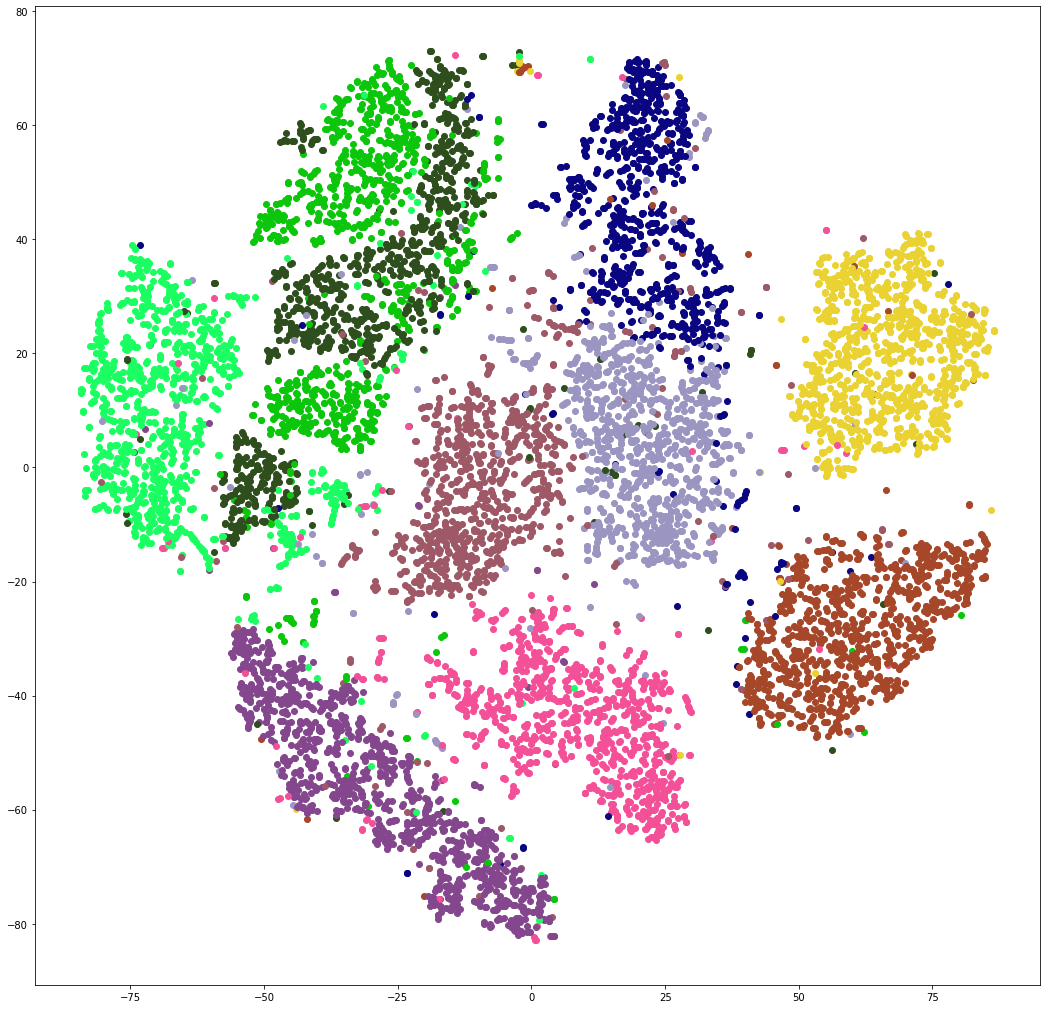

In [99]:
colors = [tuple(np.random.uniform(size=3)) for _ in range(10)]
plt.figure(figsize=(18,18))
for i in range(10000):
    plt.scatter(X_trans[i,0],X_trans[i,1],color=colors[int(y_[i])])
plt.show()

In [100]:
kmeans, ac = KMeans(n_clusters=10), AgglomerativeClustering(n_clusters=10)
kmeans_silhouette_score_tsne = silhouette_score(X_, kmeans.fit_predict(X_trans))
ac_silhouette_score_tsne = silhouette_score(X_, ac.fit_predict(X_trans))
kmeans, ac = KMeans(n_clusters=10), AgglomerativeClustering(n_clusters=10)
kmeans_v_measure_score_tsne = v_measure_score(y_, kmeans.fit_predict(X_trans))
ac_v_measure_score_tsne = v_measure_score(y_, ac.fit_predict(X_trans))

In [101]:
pd.DataFrame([
    ['orig',kmeans_silhouette_score,ac_silhouette_score,kmeans_v_measure_score,ac_v_measure_score],
    ['tSNE',kmeans_silhouette_score_tsne,ac_silhouette_score_tsne,kmeans_v_measure_score_tsne,ac_v_measure_score_tsne]
    ], columns=['type','kmeans sil','ac sil','kmeans v','ac v']).set_index('type')

,kmeans sil,ac sil,kmeans v,ac v
type,,,,
orig,0.062269,0.032955,0.477545,0.662548
tSNE,0.039510,0.036089,0.733178,0.734007


По метрике `silhouette_score` лучше себя показывает модель `KMeans`.

По метрике `v_measure_score` лучше себя показывает модель `Agglomerative+tSNE`.

Получено улучшение по метрике `v-measure score`.

In [102]:
ns = np.arange(2,4)
kmeans_silhouette_score_tsne = []
ac_silhouette_score_tsne = []
kmeans_v_measure_score_tsne = []
ac_v_measure_score_tsne = []
for n in ns:
    X_trans = TSNE(n_components=n).fit_transform(X_)
    kmeans, ac = KMeans(n_clusters=10), AgglomerativeClustering(n_clusters=10)
    kmeans_silhouette_score_tsne.append(silhouette_score(X_, kmeans.fit_predict(X_trans)))
    ac_silhouette_score_tsne.append(silhouette_score(X_, ac.fit_predict(X_trans)))
    kmeans, ac = KMeans(n_clusters=10), AgglomerativeClustering(n_clusters=10)
    kmeans_v_measure_score_tsne.append(v_measure_score(y_, kmeans.fit_predict(X_trans)))
    ac_v_measure_score_tsne.append(v_measure_score(y_, ac.fit_predict(X_trans)))

D:\Python 3.9\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
D:\Python 3.9\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
D:\Python 3.9\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
D:\Python 3.9\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


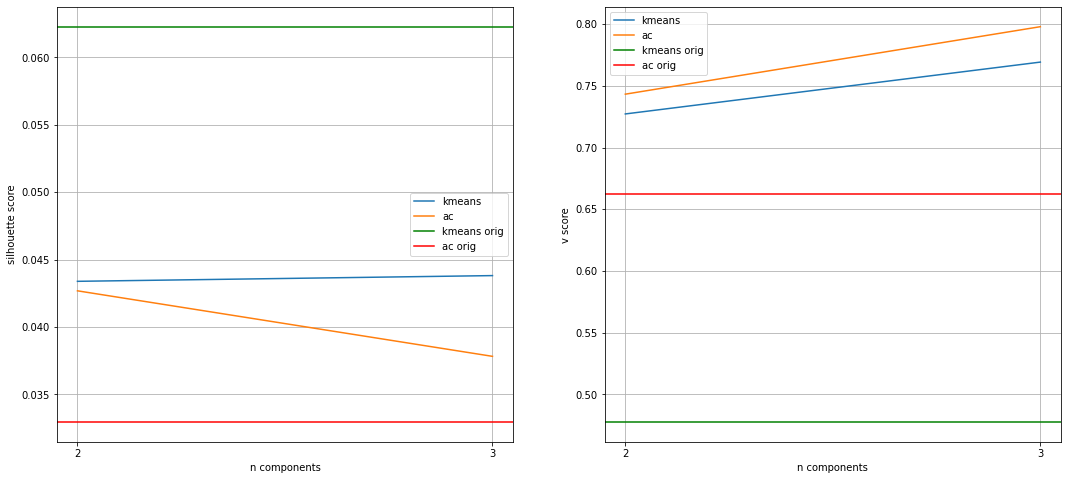

In [103]:
f, ax = plt.subplots(1,2,figsize=(18,8))
ax[0].set_ylabel('silhouette score')
ax[1].set_ylabel('v score')
ax[0].plot(ns,kmeans_silhouette_score_tsne,label='kmeans')
ax[0].plot(ns,ac_silhouette_score_tsne,label='ac')
ax[0].axhline(kmeans_silhouette_score,label='kmeans orig',color='green')
ax[0].axhline(ac_silhouette_score,label='ac orig',color='red')
ax[1].plot(ns,kmeans_v_measure_score_tsne,label='kmeans')
ax[1].plot(ns,ac_v_measure_score_tsne,label='ac')
ax[1].axhline(kmeans_v_measure_score,label='kmeans orig',color='green')
ax[1].axhline(ac_v_measure_score,label='ac orig',color='red')
for a in ax:
    a.set_xticks(ns)
    a.grid()
    a.set_xlabel('n components')
    a.legend()
plt.show()

По метрике `v_measure_score` получено улучшение при модели `Agglomerative+tSNE(n_components=3)`.

In [104]:
print(f'v_measure_score (Agglomerative+tSNE(n_components=3)) = {ac_v_measure_score_tsne[np.where(ns==3)[0][0]]}')

v_measure_score (Agglomerative+tSNE(n_components=3)) = 0.7978980910321957


Таким образом получаем лучшие обнаруженные модели:

По метрике `silhouette_score` : `KMeans` (0.062269).

По метрике `v_measure_score` : `Agglomerative+tSNE(n_components=3)` (0.797898).

В качестве лучшей модели выберем `Agglomerative+tSNE(n_components=3)`.

D:\Python 3.9\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
D:\Python 3.9\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


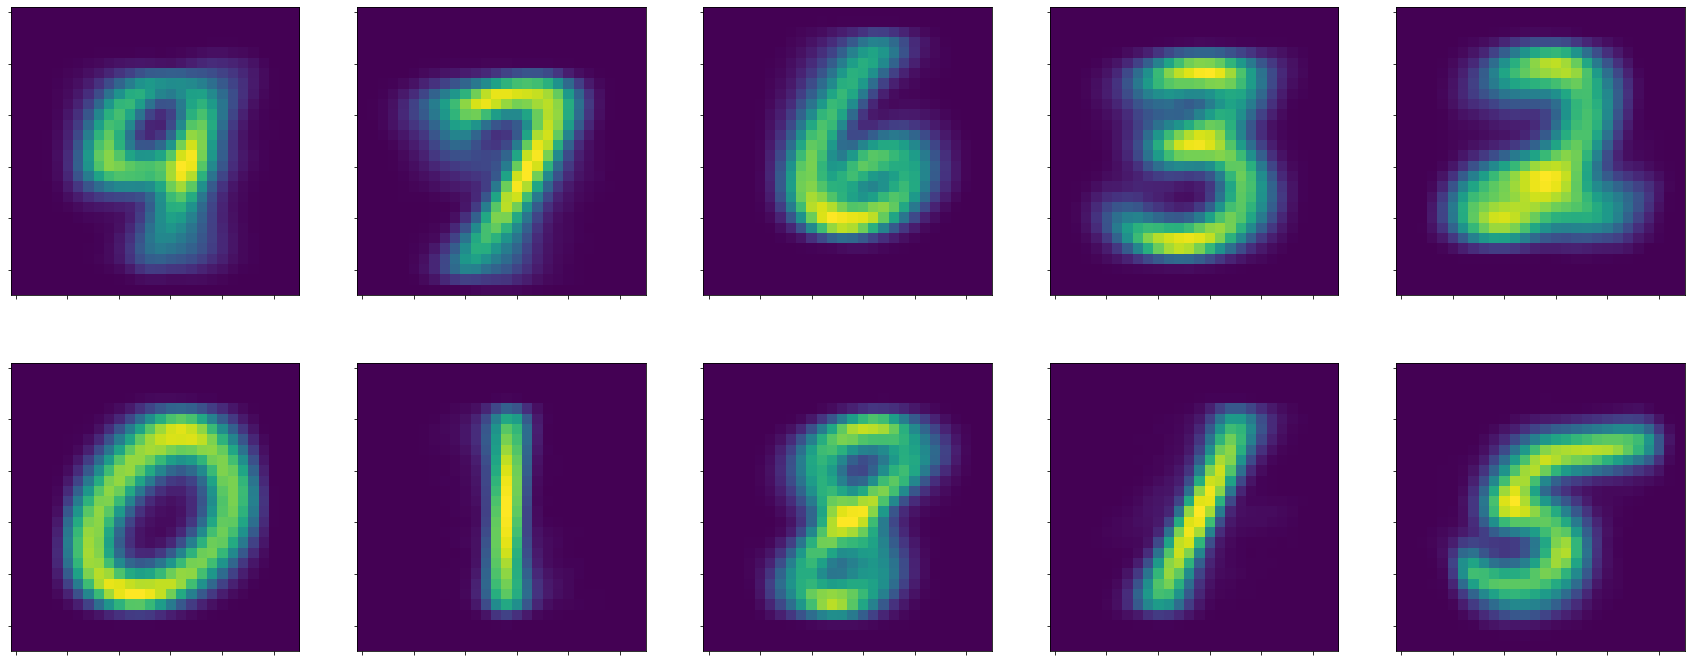

In [105]:
ac = AgglomerativeClustering(n_clusters=10)
y_pred = ac.fit_predict(TSNE(n_components=3).fit_transform(X_))

clf = NearestCentroid()
clf.fit(X_, y_pred)

f, ax = plt.subplots(2,5,figsize=(30,12))
f.patch.set_color('white')
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(clf.centroids_[5*i+j].reshape(28,28))
        ax[i,j].tick_params(labelbottom=False, labelleft=False)
plt.show()

Изображены центры кластеров лучшей модели.

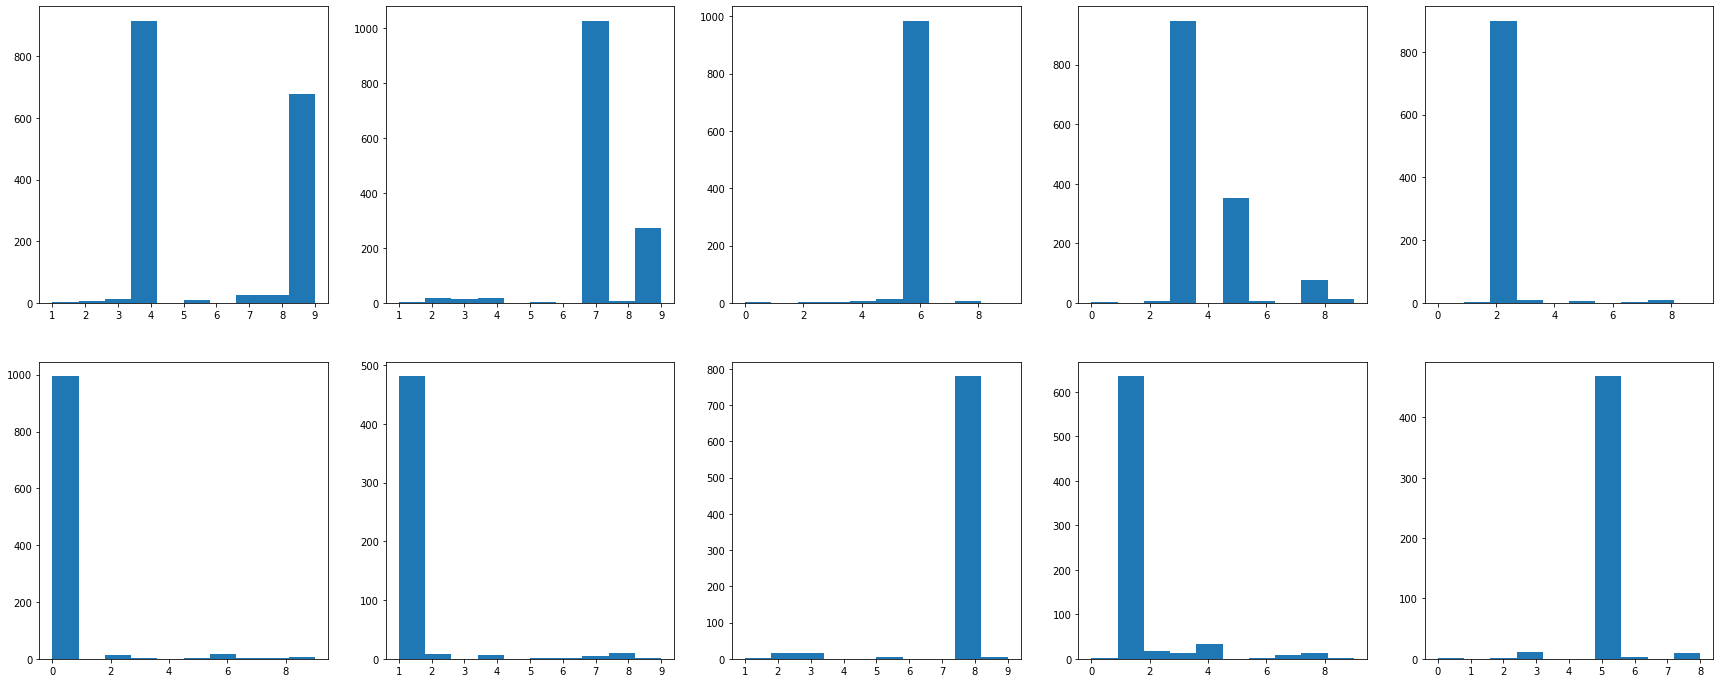

In [128]:
f, ax = plt.subplots(2,5,figsize=(30,12))
for i in range(2):
    for j in range(5):
        ax[i,j].hist(y_[y_pred==5*i+j])

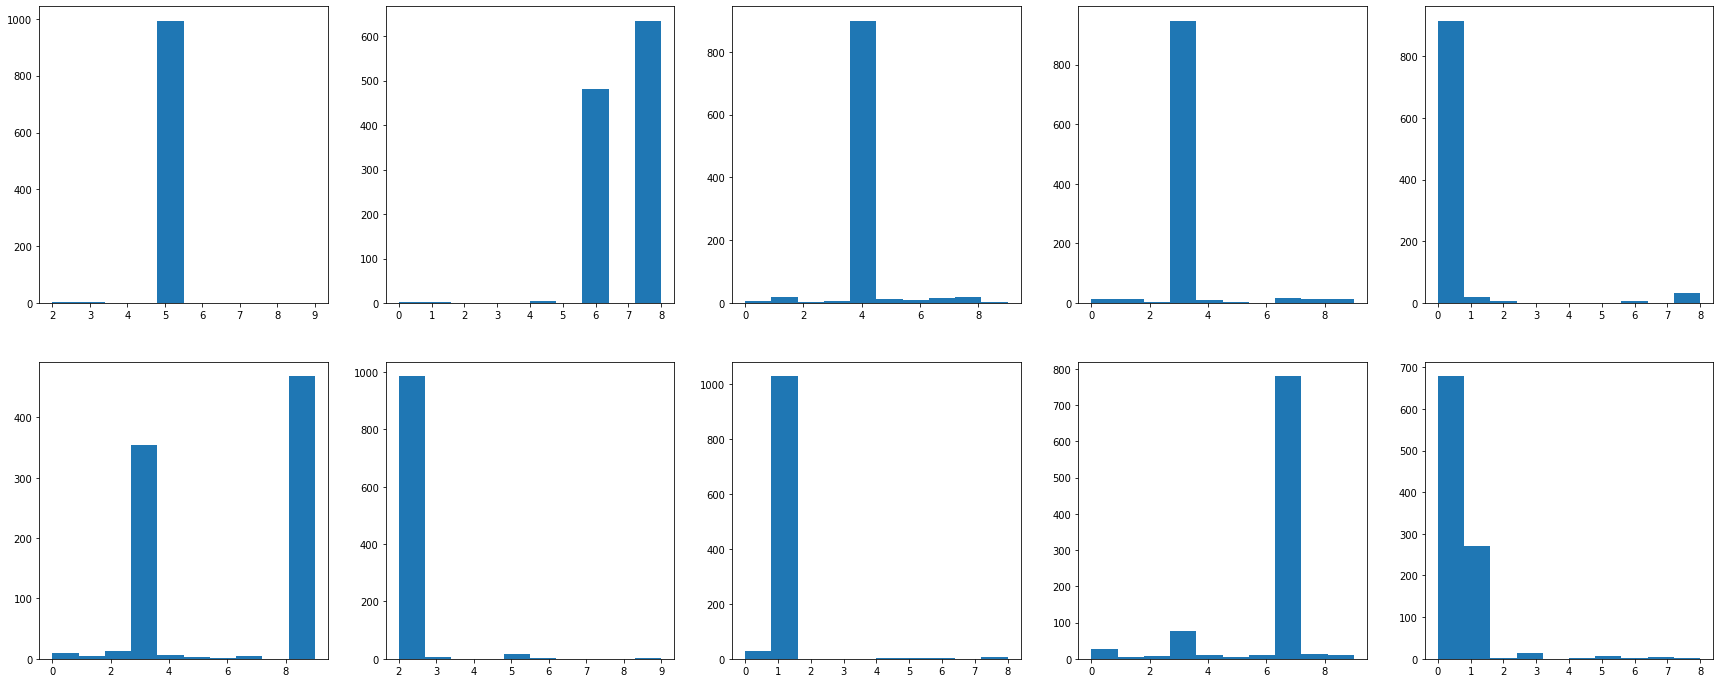

In [130]:
f, ax = plt.subplots(2,5,figsize=(30,12))
for i in range(2):
    for j in range(5):
        ax[i,j].hist(y_pred[y_==5*i+j])

Видим, что модель хорошо отличает цифры 0(5), 2(4), 6(2), 8(7).

Затруднено распознавание цифр 3(3), 7(1).

Модель разбила на 2 класса представление цифры 1: прямой и наклонный. 